<a href="https://colab.research.google.com/github/caio-torres-seares/sistema-de-recomendacao/blob/main/sistema_de_recomendacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os, glob, json, uuid, shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.applications import EfficientNetB0, efficientnet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [4]:
DRIVE_PATH = "/content/drive/MyDrive/Projetos/datasets/similarity-recommendation"

IMG_SIZE = 224                                # Tamanho padrão de entrada do modelo
CATALOG_DIR = f"{DRIVE_PATH}/products"        # Caminho base do catálogo de imagens
EMB_PATH = f"{DRIVE_PATH}/embeddings.npy"     # Arquivo para salvar embeddings
PATHS_PATH = f"{DRIVE_PATH}/image_paths.json" # Arquivo para salvar lista de caminhos

In [5]:
os.makedirs(f"{CATALOG_DIR}/bicicleta", exist_ok=True)
os.makedirs(f"{CATALOG_DIR}/mouse", exist_ok=True)
os.makedirs(f"{CATALOG_DIR}/relogio", exist_ok=True)
os.makedirs(f"{CATALOG_DIR}/teclado", exist_ok=True)

In [6]:
# Pasta com as imagens aumentadas salvas
AUG_DIR = f"{CATALOG_DIR}_augmented"
os.makedirs(AUG_DIR, exist_ok=True)

# Gerador de augmentação
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_images(category, n_aug=10):
    src_dir = f"{CATALOG_DIR}/{category}"
    dst_dir = f"{AUG_DIR}/{category}"
    os.makedirs(dst_dir, exist_ok=True)

    images = glob.glob(f"{src_dir}/*")
    for img_path in images:
        # Força RGB
        img = Image.open(img_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
        arr = np.array(img)
        x = np.expand_dims(arr, axis=0)  # (1, 224, 224, 3)
        flow = datagen.flow(x, batch_size=1)
        for i in range(n_aug):
            batch = next(flow)[0].astype(np.uint8)
            new_name = f"{uuid.uuid4().hex}.jpg"
            Image.fromarray(batch).save(os.path.join(dst_dir, new_name))
    print(f"Augmentadas {n_aug} imagens para cada original em '{category}'")


# Exemplo: aplicar em todas as categorias
for category in ["bicicleta", "mouse", "relogio", "teclado"]:
    augment_images(category, n_aug=5)

Augmentadas 5 imagens para cada original em 'bicicleta'
Augmentadas 5 imagens para cada original em 'mouse'
Augmentadas 5 imagens para cada original em 'relogio'
Augmentadas 5 imagens para cada original em 'teclado'


In [7]:
# Carregar modelo EfficientNetB0 sem a camada de classificação
base_model = EfficientNetB0(weights="imagenet", include_top=False, pooling="avg")
preprocess = efficientnet.preprocess_input

def load_and_preprocess(img_path, target_size=(IMG_SIZE, IMG_SIZE)):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess(x)
    return x

def embed_image(img_path):
    x = load_and_preprocess(img_path)
    emb = base_model.predict(x, verbose=0)
    return emb.squeeze()  # vetor 1D com 1280 números

In [8]:
# Listar todas as imagens
image_paths = glob.glob(f"{CATALOG_DIR}/*/*")
print(f"Total de imagens encontradas: {len(image_paths)}")

# Extrair embeddings
embeddings = []
paths = []

for path in image_paths:
    try:
        emb = embed_image(path)
        embeddings.append(emb)
        paths.append(path)
    except Exception as e:
        print(f"Erro ao processar {path}: {e}")

embeddings = np.array(embeddings)

# Salvar os resultados
np.save(EMB_PATH, embeddings)
with open(PATHS_PATH, "w") as f:
    json.dump(paths, f)

print(f"✅ Extraídos {len(embeddings)} embeddings e salvos com sucesso.")

Total de imagens encontradas: 40
✅ Extraídos 40 embeddings e salvos com sucesso.


In [9]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def show_similar_images(query_path, top_k=5):
    query_emb = embed_image(query_path).reshape(1, -1)
    sims = cosine_similarity(query_emb, embeddings)[0]
    top_indices = np.argsort(sims)[::-1][:top_k]

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(top_indices):
        img = Image.open(paths[idx])
        plt.subplot(1, top_k, i + 1)
        plt.imshow(img)
        plt.title(f"Score: {sims[idx]:.2f}")
        plt.axis("off")
    plt.suptitle("Imagens mais parecidas com a consulta")
    plt.show()

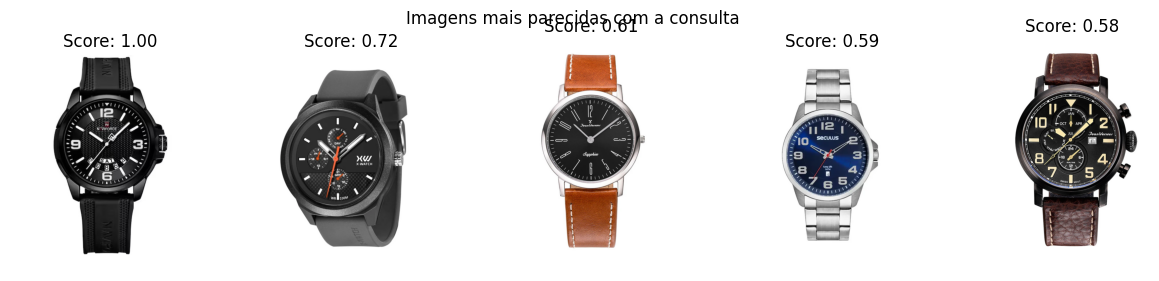

In [10]:
PRODUCT_DIR = f"{DRIVE_PATH}/products/relogio/relogio05.jpg"
show_similar_images(PRODUCT_DIR)

In [11]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    f"{AUG_DIR}",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=16,
    class_mode="categorical",
    subset="training"
)

val_gen = datagen.flow_from_directory(
    f"{AUG_DIR}",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=16,
    class_mode="categorical",
    subset="validation"
)

Found 664 images belonging to 4 classes.
Found 166 images belonging to 4 classes.


In [12]:
# Montar o modelo com transfer learning
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base.trainable = False  # congelar base

num_classes = train_gen.num_classes # Forma segura de pegar o número de classes


x = base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
output = Dense(num_classes, activation="softmax")(x)  # 4 classes

model = Model(inputs=base.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0005), loss="categorical_crossentropy", metrics=["accuracy"])

In [13]:
# Treinar o modelo
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 63s 885ms/step - accuracy: 0.2473 - loss: 1.4041 - val_accuracy: 0.2771 - val_loss: 1.3845
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.2460 - loss: 1.4009 - val_accuracy: 0.2771 - val_loss: 1.3824
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.2722 - loss: 1.3875 - val_accuracy: 0.2771 - val_loss: 1.3944
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.2560 - loss: 1.4141 - val_accuracy: 0.2952 - val_loss: 1.3862
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.2751 - loss: 1.3890 - val_accuracy: 0.2771 - val_loss: 1.3790
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.2537 - loss: 1.3975 - val_accuracy: 0.2410 - val_loss: 1.3845
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.2873 - loss: 1.3950 - val_accuracy: 0.2771 - val_loss: 1.3776
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.2654 - loss: 1.3875 - val_accuracy: 0.5181 -

In [14]:
# Classificar novas imagens
def classify_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    x = image.img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)
    pred = model.predict(x)
    class_idx = np.argmax(pred)
    class_name = list(train_gen.class_indices.keys())[class_idx]
    print(f"Classe prevista: {class_name} (confiança: {pred[0][class_idx]:.2f})")

In [15]:
from google.colab import files

# Upload (pode ser mais de um arquivo)
uploaded = files.upload()

# Pega o nome do primeiro arquivo enviado
for filename in uploaded.keys():
    print(f"🔹 Testando imagem enviada: {filename}")
    result = classify_image(filename)
    print("Resultado:", result)

Saving bike teste.webp to bike teste.webp
🔹 Testando imagem enviada: bike teste.webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Classe prevista: bicicleta (confiança: 0.27)
Resultado: None


In [16]:
def recommend_by_class_and_similarity(query_path, top_k=5):
    # Classificar a imagem
    img = image.load_img(query_path, target_size=(IMG_SIZE, IMG_SIZE))
    x = image.img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)
    pred = model.predict(x)
    class_idx = np.argmax(pred)
    class_name = list(train_gen.class_indices.keys())[class_idx]
    print(f"Classe prevista: {class_name}")

    # Filtrar imagens do catálogo pela mesma classe
    filtered = [(embeddings[i], p) for i, p in enumerate(paths) if f"/{class_name}/" in p]

    # Separar embeddings e paths, excluindo a própria imagem consultada
    filtered_embs, filtered_paths = zip(
        *[(e, p) for e, p in filtered if os.path.basename(p) != os.path.basename(query_path)]
    )

    # Calcular similaridade
    query_emb = embed_image(query_path).reshape(1, -1)
    sims = cosine_similarity(query_emb, filtered_embs)[0]
    top_indices = np.argsort(sims)[::-1][:top_k]

    # Mostrar resultados
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(top_indices):
        img = Image.open(filtered_paths[idx])
        plt.subplot(1, top_k, i + 1)
        plt.imshow(img)
        plt.title(f"Score: {sims[idx]:.2f}")
        plt.axis("off")
    plt.suptitle(f"Recomendações na classe '{class_name}'")
    plt.show()


In [17]:
def recommend_by_class_and_similarity(query_path, top_k=5):
    # Classificar a imagem
    img = image.load_img(query_path, target_size=(IMG_SIZE, IMG_SIZE))
    x = image.img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)
    pred = model.predict(x)
    class_idx = np.argmax(pred)
    class_name = list(train_gen.class_indices.keys())[class_idx]
    print(f"Classe prevista: {class_name}")

    # Filtrar imagens do catálogo pela mesma classe
    filtered_paths = []
    filtered_embs = []
    for i, p in enumerate(paths):
        if f"/{class_name}/" in p:
            # evita incluir a própria imagem consultada
            if os.path.basename(p) != os.path.basename(query_path):
                filtered_paths.append(p)
                filtered_embs.append(embeddings[i])

    # Calcular similaridade
    query_emb = embed_image(query_path).reshape(1, -1)
    sims = cosine_similarity(query_emb, filtered_embs)[0]
    top_indices = np.argsort(sims)[::-1][:top_k]

    # Mostrar resultados
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(top_indices):
        img = Image.open(filtered_paths[idx])
        plt.subplot(1, top_k, i + 1)
        plt.imshow(img)
        plt.title(f"Score: {sims[idx]:.2f}")
        plt.axis("off")
    plt.suptitle(f"Recomendações na classe '{class_name}'")
    plt.show()

    # Retorna também as paths se quiser usar depois
    return [filtered_paths[idx] for idx in top_indices]


Saving bike teste.webp to bike teste (2).webp
🔹 Gerando recomendações para: bike teste (2).webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Classe prevista: bicicleta


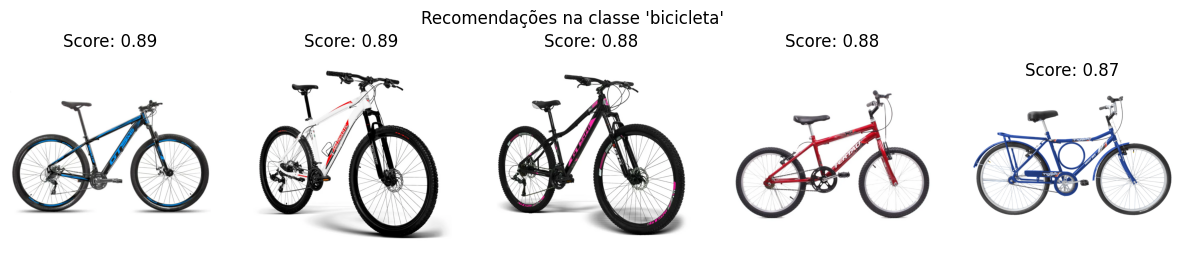

In [22]:
from google.colab import files

# Upload (um ou mais arquivos)
uploaded = files.upload()

# Para cada imagem enviada roda a recomendação
for filename in uploaded.keys():
    print(f"🔹 Gerando recomendações para: {filename}")
    recs = recommend_by_class_and_similarity(filename)